In [1]:
import sys
sys.path.append('../')
import Common_Module.CMStat as CMStat

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer


diabetes_data = pd.read_csv('./diabetes.csv')
print(diabetes_data['Outcome'].value_counts())

0    500
1    268
Name: Outcome, dtype: int64


Negative값 0이 500개로 상대적으로 많습니다.

In [2]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Null값은 없으며 피처의 타입은 모두 숫자형입니다. 이제 로지스틱 회귀를 이용해 예측 모델을 생성해 보겠습니다. 데이터 세트를 피처 데이터 세트와 클래스 데이터 세트로 나누고 학습 데이터 세트와 테스트 데이터 세트로 분리하겠습니다.

In [3]:
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
lr_clf = lr_clf.predict_proba(X_test)[:,1]
# pred_proba = lr_clf.predict_proba(X_test)[:, 1]

CMStat.get_clf_eval(y_test, pred)

오차행렬:
 [[87 13]
 [22 32]]

정확도: 0.7727
정밀도: 0.7111
재현율: 0.5926
F1: 0.6465
AUC: 0.7313


c:\users\hana\pycharmprojects\hanatour\venv\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass average=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


예측 정확도가 76%, 정밀도가 71%로 측정됐습니다. 전체 데이터의 62%가 Negative이므로 정확도보다는 재현율 성능에 조금 더 초점을 맞춰 보겠습니다. 먼저 정밀도 재현율 곡선을 보고 임계값별 정밀도와 재현율 값의 변화를 확인하겠습니다.

In [4]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
CMPlot.precision_recall_curve_plot(y_test, pred_proba_c1)

AttributeError: 'numpy.ndarray' object has no attribute 'predict_proba'

(Python 코드 확인) 재현율 곡선을 보면 임곗값을 0.42 정도로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞출 것 같습니다. 하지만 두 개의 지표 모두 0.7이 안 되는 수치로 보입니다. 여전히 두 지표의 값이 낮습니다. 임곗값을 인위적으로 조작하기 전에 다시 데이터 값을 점검하겠습니다. 먼저 원본 데이터 DataFrame의 Describe() 메서드를 호출해 피처 값의 분포도를 살펴보겠습니다.

In [5]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


min()값이 0으로 돼 있는 피처가 상당히 많습니다. 예를 들어 Glucose피처는 포도당 수치인데 min값이 0인 것은 말이 되지 않습니다. Glucose피처의 히스토그램을 확인해 보면 0값이 일정 수준 존재하는 것을 알 수 있습니다.

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

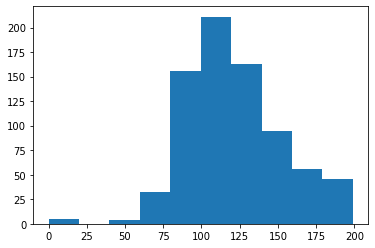

In [6]:
plt.hist(diabetes_data['Glucose'], bins=10)

다른 피처에 대해 0값의 건수 및 전체 데이터 건수 대비 몇 퍼센트의 비율로 존재하는지 확인해 보겠습니다.

In [55]:
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
total_count = diabetes_data['Glucose'].count()

for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0건수는 {1}, 퍼센트 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0건수는 5, 퍼센트 0.65 %
BloodPressure 0건수는 35, 퍼센트 4.56 %
SkinThickness 0건수는 227, 퍼센트 29.56 %
Insulin 0건수는 374, 퍼센트 48.70 %
BMI 0건수는 11, 퍼센트 1.43 %


SkinThickness와 Insulin의 0값은 각각 전체의 29.56%, 48.7%로 대단히 많습니다. 전체 데이터 건수가 많지 않기 때문에 이들 데이터를 일괄적으로 삭제할 경웅는 학습을 효과적으로 수행하기 어려울 것 같습니다. 위 피처의 0값을 평균값으로 대체하겠습니다.

In [56]:
#zero_feature 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features)

0값을 평균값으로 대체한 데이터 세트에 피처 스케일링을 적용해 변환하겠습니다. 로지스틱 회귀의 경우 일반적으로 숫자 데이터에 스케일링을 적용하는 것이 좋습니다. 이후에 다시 학습/테스트 데이터 세트로 나누고 로지스틱 회귀를 적용해 성능 평가 지표를 확인하겠습니다.

In [57]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

CMStat.get_clf_eval(y_test, pred)

오차행렬:
 [[90 10]
 [21 33]]

정확도: 0.7987
정밀도: 0.7674
재현율: 0.6111
F1: 0.6804
AUC: 0.7556


c:\users\hana\pycharmprojects\hanatour\venv\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass average=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


데이터 변환과 스케일링을 통해 성능 수치가 일정 수준 개선됐습니다. 하지만 여전히 재현유 수치는 개선이 필요해 보입니다. 분류 결정 임곗값을 변화시키면서 재현율 값의 성능 수치가 어느 정도나 개선되는지 확인해 보겠습니다. 

In [10]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
print(X_test)
pred_proba = lr_clf.predict_proba(X_test)
CMStat.get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
81             2       74              0              0        0   0.0   
682            0       95             64             39      105  44.6   
169            3      111             90             12       78  28.4   
693            7      129             68             49      125  38.5   
9              8      125             96              0        0   0.0   
..           ...      ...            ...            ...      ...   ...   
293            1      128             48             45      194  40.5   
344            8       95             72              0        0  36.8   
650            1       91             54             25      100  25.2   
415            3      173             84             33      474  35.7   
505           10       75             82              0        0  33.3   

     DiabetesPedigreeFunction  Age  
81                      0.102   22  
682                     0.366   22  


AttributeError: 'LogisticRegression' object has no attribute 'lr_clf'

위 결과를 근거로 정확도와 정밀도를 희생하고 재현율을 높이는 데 가장 좋은 임곗값은 0.33으로 재현율 값이 0.7963입니다. 하지만 정밀도가 0.5972로 매우 저조해졌으니 극단적인 선택으로 보입니다. 

In [7]:
#임곗값을 0.48로 설정한 Binarizer생성
binarizer = Binarizer(threshold=0.48)

pred_th_048 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))
CMStat.get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

NameError: name 'pred_proba' is not defined